## SVD의 구현

* 계수가 $r$인 행렬 $A$의 특이값분해(SVD)가 $A = U\Sigma V^{\rm T}$일 때, $U$와 $V$의 $i$번째 열벡터를 각각 $\mathbf u_i$, $\mathbf v_i$, $\Sigma$의 $i$번째 대각성분을 $\sigma_i$라 할 때, 
$$ A = \sum_{i=1}^r \sigma_i \mathbf u_i\mathbf v_i^{\rm T},\quad (\sigma_1\ge \sigma_2\ge \cdots\sigma_r>0)$$


* $B=A^{\rm T}A$라 할 때, $B = \sum_{i=1}^r \sigma_i^2 \mathbf v_i\mathbf v_i^{\rm T}$이므로 $B\mathbf v_i= \sigma_i^2 \mathbf v_i$이고 이로부터 $B^k\mathbf v_i = \sigma_i^{2k}\mathbf v_i$


* 따라서 임의의 $\mathbf x =\sum_{i=1}^r c_i\mathbf v_i$에 대하여 $B^k\mathbf x = \sum_{i=1}^r c_i \sigma_i^{2k}\mathbf v_i$


* $\sigma_1$이 $\sigma_i \ (i\neq 1)$보다 큰 경우 
$$\displaystyle{\lim_{k\to \infty}\dfrac {B^{k}\mathbf x}{||B^{k}\mathbf x||}=\lim_{k\to \infty}\sum_{i=1}^r \dfrac{c_i\sigma_i^{2k}}{\sqrt{c_1^2\sigma_1^{4k}+\cdots c_r^2\sigma_r^{4k}}}\mathbf v_i}= \mathbf v_1 $$



* 한편 $A\mathbf v_i = \sigma_i \mathbf u_i$이므로 $\mathbf v_i$를 알면 $\sigma_i = ||A\mathbf v_i||$이고 
$\displaystyle{\mathbf u_i = \dfrac{A\mathbf v_i}{||A\mathbf v_i||}}$

* $\mathbf v_1,\ \mathbf u_1,\ \sigma_1$을 구하고 나면 
$$B = (A-\sigma_1\mathbf u_1\mathbf v_1^{\rm T})^{\rm T}(A-\sigma_1\mathbf u_1\mathbf v_1^{\rm T})= \sum_{i=2}^r \sigma_i^2\mathbf v_i \mathbf v_i^{\rm T}$$
에 대해 위 과정을 반복하면 $\sigma_2>\sigma_3$인 경우 $\mathbf v_2,\ \mathbf u_2,\ \sigma_2$를 구할 수 있고, 이를 계속 반복하여 $A$에 대한 SVD를 구할 수 있음



* 특이값 사이의 비가 $1$에 가까운 경우 $\mathbf v_i$로 수렴하는데 시간이 많이 걸림



* 일반적으로는 행렬의 왼쪽에 Householder reflection을 적용하여 QR 분해하는 아이디어와 유사하게 행렬의 양쪽에서 Householder reflection을 적용하여 SVD를 구하는 방법을 많이 사용


In [1]:
import numpy as np
from numpy.linalg import norm

def randomUnitVector(n):
    unnormalized = np.random.randn(n)
    return unnormalized / np.sqrt(np.sum(unnormalized ** 2))


def svd1d(A, epsilon=1e-10, verbose=False):
    ''' 가장 큰 특잇값에 대응되는 오른쪽(왼쪽) 특이벡터 구하기 '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = A.T @ A
    else:
        B = A @ A.T

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = B @ lastV
        currentV = currentV / norm(currentV)

        if np.abs(np.dot(currentV, lastV)) > 1 - epsilon: # 두 단위벡터 사이의 각
            if verbose:
                print("converged in {} iterations!".format(iterations))
            return currentV


def svd0(A, k=None, epsilon=1e-10, verbose=False):
    '''
        A의 특이값분해를 계산
        입력: A는 행렬, k는 계산하려는 특이값의 개수 (k가 None이면 full-rank)
        ndarray를 적극적으로 활용하지 않는 구현
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdList = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        tempMatrix = A.copy()

        for singularValue, u, v in svdList[:i]:
            tempMatrix -= singularValue * np.outer(u, v) # np.outer(u,v)는 u[:,np.newaxis]@ v[:,np.newaxis].T와 동일

        if n > m:
            v = svd1d(tempMatrix, epsilon=epsilon, verbose=verbose)  # next singular vector
            u_unnormalized = A @ v
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd1d(tempMatrix, epsilon=epsilon, verbose = verbose)  # next singular vector
            v_unnormalized = A.T @ u
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdList.append((sigma, u, v))

    sv, RowU, RowV = [np.array(x) for x in zip(*svdList)] # A = U S V^T에서 uRow는 U^T, vRow는 V^T
    return sv, RowU.T, RowV

In [2]:
def svd(A, k=None, epsilon=1e-10, verbose=False):
    '''
        A의 특이값분해를 계산
        입력: A는 행렬, k는 계산하려는 특이값의 개수 (k가 None이면 full-rank)
        ndarray를 적극적으로 활용한 구현
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    
    if k is None:
        k = min(n, m)
    
    RowU = np.zeros((k,n))
    RowV = np.zeros((k,m))
    sv = np.zeros(k)

    tempMatrix = A.copy()
    
    for i in range(k):
        if n > m:
            RowV[i] = svd1d(tempMatrix, epsilon=epsilon, verbose=verbose)  # next singular vector
            u_unnormalized = A @ RowV[i]
            sv[i] = norm(u_unnormalized)  # next singular value
            RowU[i] = u_unnormalized / sv[i]
        else:
            RowU[i] = svd1d(tempMatrix, epsilon=epsilon, verbose = verbose)  # next singular vector
            v_unnormalized = A.T @ u
            sv[i] = norm(v_unnormalized)  # next singular value
            RowV[i] = v_unnormalized / sv[i]
            
        tempMatrix -= sv[i] * np.outer(RowU[i], RowV[i]) # np.outer(u,v)는 u[:,np.newaxis]@ v[:,np.newaxis].T와 동일

    return sv, RowU.T, RowV

In [3]:
A = np.array([
    [2, 5, 3],
    [1, 2, 1],
    [4, 1, 1],
    [3, 5, 2],
    [5, 3, 1],
    [4, 5, 5],
    [2, 4, 2],
    [2, 2, 5]
], dtype='float64')

In [4]:
s, u, vt = svd0(A, verbose=True)

converged in 6 iterations!
converged in 28 iterations!
converged in 2 iterations!


In [5]:
s

array([15.09626916,  4.30056855,  3.40701739])

In [6]:
u

array([[-0.39458523, -0.23924087,  0.35445439],
       [-0.15830232, -0.03055132,  0.15299698],
       [-0.22155209,  0.52086563, -0.39333896],
       [-0.39692636,  0.08648428,  0.41053049],
       [-0.34630266,  0.64128849, -0.07381603],
       [-0.53347446, -0.1916873 , -0.19949722],
       [-0.31660464, -0.06110264,  0.30599395],
       [-0.32840216, -0.45969708, -0.62355669]])

In [7]:
vt

array([[-0.54184848, -0.6707099 , -0.50650613],
       [ 0.75152851, -0.11682087, -0.64927481],
       [-0.37630456,  0.73246237, -0.56735682]])

In [8]:
A_rec = (u*s) @ vt

In [9]:
ss, uu, vvt = svd(A, verbose=True)

converged in 6 iterations!
converged in 23 iterations!
converged in 2 iterations!


In [10]:
(uu * ss) @ vvt

array([[2., 5., 3.],
       [1., 2., 1.],
       [4., 1., 1.],
       [3., 5., 2.],
       [5., 3., 1.],
       [4., 5., 5.],
       [2., 4., 2.],
       [2., 2., 5.]])

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
kcha = plt.imread('kcha.png')
kcha2 = np.mean(kcha, axis=2)

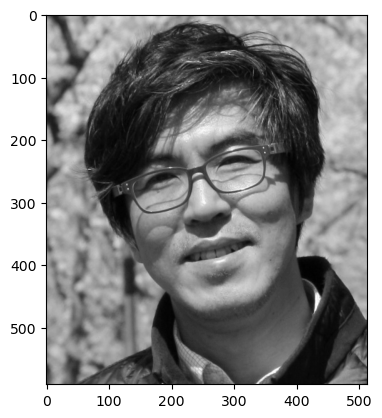

In [13]:
plt.imshow(kcha2,cmap='gray')

In [14]:
s, u, vt = svd(kcha2, k=40, verbose=False)

In [15]:
s[:40]

array([252.61520125,  62.56975256,  45.82912773,  30.0383472 ,
        26.26540451,  24.81834686,  23.0480504 ,  21.18730096,
        17.89815421,  16.73109378,  15.21898575,  13.21814305,
        12.97294387,  11.87958297,  11.18342258,   9.95427122,
         9.86028132,   9.44411885,   8.16796596,   7.87009203,
         7.6542539 ,   7.0822825 ,   6.79409593,   6.36853085,
         5.96147113,   5.8306243 ,   5.55874957,   5.2598987 ,
         5.13229008,   5.02113177,   4.77536371,   4.60539478,
         4.4880976 ,   4.44561094,   4.2655145 ,   4.11910536,
         3.95594465,   3.75898026,   3.73092678,   3.65041198])

In [16]:
kcha_rec = (u*s) @ vt

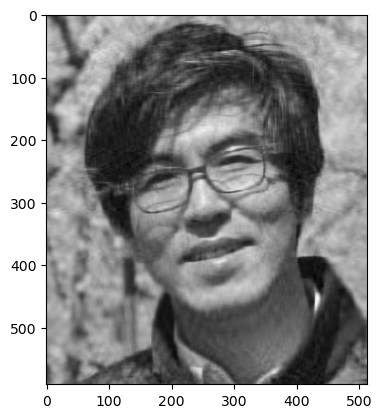

In [17]:
plt.imshow(kcha_rec, cmap='gray')

- SVD를 구현할 때, python의 리스트와 numpy의 ndarray를 사용하여 구현한 것의 시간 차이 비교

In [18]:
from time import time

In [19]:
start1 = time()
s, u, vt = svd0(kcha2, k=100)
print(time()-start1)

22.982590198516846


In [20]:
start2 = time()
s, u, vt = svd(kcha2, k=100)
print(time()-start2)

2.3699283599853516


- numpy.linalg 모듈에 구현되어 있는 SVD의 사용법 

>- `np.linalg.svd(a, full_matrices=True, compute_uv=True, hermitian=False)` : 정사각행렬이 아니면 `full-matrices=False`로 설정
>- 반환: `u, s, vt` : `a`$\approx$ `u @ np.diag(s) @ vh = (u * s) @ vh`

In [21]:
start3 = time()
u, s, vt = np.linalg.svd(kcha2, False)
print(time()-start3)

0.14561033248901367


In [22]:
u.shape, s.shape, vt.shape

((591, 513), (513,), (513, 513))

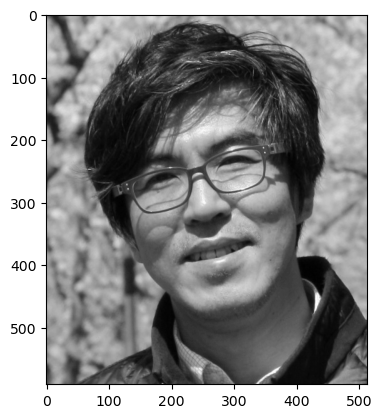

In [23]:
plt.imshow((u*s) @ vt,cmap='gray')

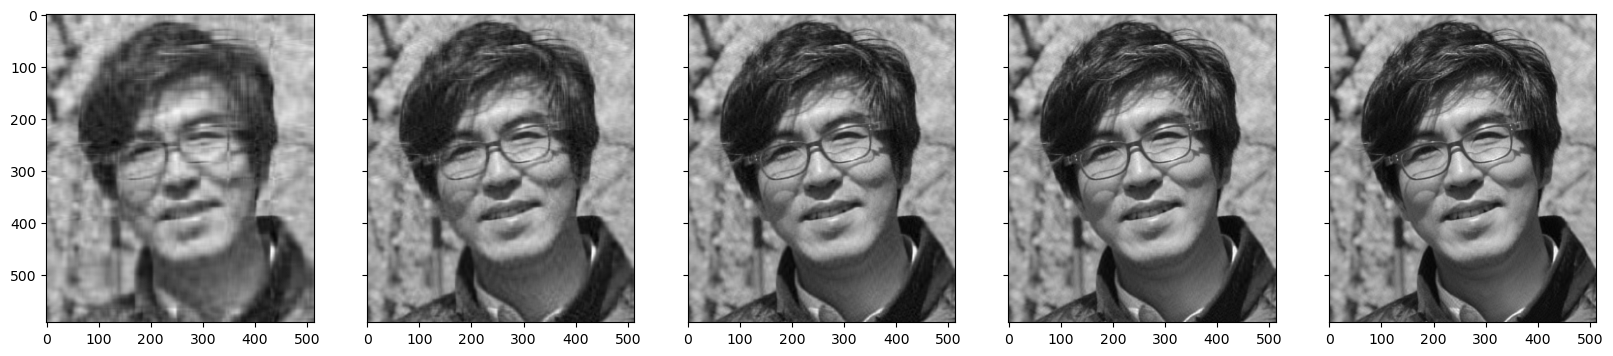

In [24]:
figs, axes = plt.subplots(1,5, sharex=True, sharey=True,figsize=(20,100))
for i in range(5):
    axes[i].imshow((u[:,:20*(i+1)]*s[:20*(i+1)])@vt[:20*(i+1),:],cmap='gray')